[*********************100%***********************]  3 of 3 completed


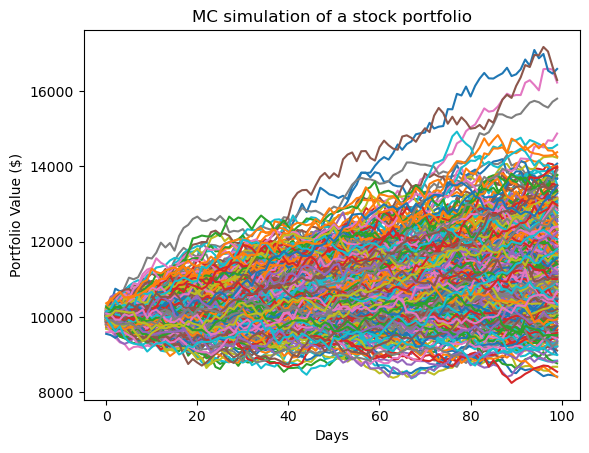

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
from typing import List, Tuple


def get_data(stock_list: List[str],
             start_date: dt.datetime,
             end_date: dt.datetime) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Get data from Yahoo Finance, given a list of underlyings for a time period.

    Parameters
    ----------
    stock_list : List[str]
        List contanining underlyings.
    start_date : dt.datetime
        Start date to retrive data.
    end_date : dt.datetime
        End date to retrive data.

    Returns
    -------
    returns : pd.DataFrame
        DataFrame containing returns percentage data.
    meanReturns : pd.Series
        Series containing mean returns.
    covMatrix : pd.DataFrame
        DataFrame containing covariance matrix.

    """
    tickers = yf.download(stock_list, start=start_date, end=end_date)['Close']
    returns = tickers.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    returns = returns.dropna()

    return returns, meanReturns, covMatrix


"""
Set up main variables

-------- Memory --------
returns: pd.DataFrame
meanReturns: pd.Series
covMatrix: pd.DataFrame
"""
underlyings: List[str] = ['MSFT', 'AAPL', 'GOOG']
end_date: dt.datetime = dt.datetime.now()
start_date: dt.datetime = end_date - dt.timedelta(days=600)

# Get data
returns, meanReturns, covMatrix = get_data(underlyings, start_date, end_date)

# Calculate weights
weights: np.ndarray = np.random.random(len(returns.columns))
weights /= np.sum(weights)

# Calculate portfolio returns
returns['portfolio'] = returns.dot(weights)

# Monte Carlo Simulation
mc_sims: int = 400  # number of simulations
T: int = 100  # timeframe in days

# Mean returns matrix for the simulation
meanM: np.ndarray = np.full(shape=(T, len(weights)),
                            fill_value=meanReturns.values)
meanM = meanM.T  # Transpose matrix

# Matrix to hold the simulations
portfolio_sims: np.ndarray = np.full(shape=(T, mc_sims), fill_value=0.0)

# Initial portfolio value
initialPortfolio: float = 10000

# Cholesky decomposition for the covariance matrix
L: np.ndarray = np.linalg.cholesky(covMatrix)

for m in range(mc_sims):
    # MC loops
    Z: np.ndarray = np.random.normal(
        size=(T, len(weights)))  # T x len(weights)
    # Corrected to ensure dimensions match
    dailyReturns: np.ndarray = meanM.T + np.dot(Z, L.T)
    portfolio_sims[:, m] = np.cumprod(
        np.dot(dailyReturns, weights) + 1) * initialPortfolio

# Plot the simulation results
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()